# Underfit, overfit и регуляризация

Целите днес:

* Да си припомним kNN
* Да създадем интуиция около overfit и underfit
* Да създадем интуиция около регуляризация

In [1]:
import numpy as np
import mglearn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import eli5.sklearn
import warnings

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons, load_boston, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

%matplotlib inline

# Overfit, underfit и генерализация

Обикновено ни интересува колко добре се справя един модел с нови данни, които не е виждал. Тъй като нямаме добър начин да измерим това (освен да го пуснем в продукция за няколко месаца и да видим), използваме друг подход – разделяме данните на тренировъчни и тестови, тренираме модела с тренировъчните и проверяваме колко добре се справя върху тестовите. Ползваме тестовите данни като proxy метрика за генерализацията.

Ако модела не се справя оптимално, обикновено говорим за две неща:

* Underfitting – модела не се справя добре нито на тестовите, нито на тренировъчните. Това значи, че не е научил достатъчно от сигнала в данните.
* Overfitting – модела се справя добре на тренировъчните данни, но зле на тестовите. Това значи, че е научил част от шума в тренировъчните данни, който (естествено) е различен в тестовите.

# Прости и сложни модели

Често си ще говорим са "сложност" на моделите:

* "Сложността" е условно понятие, което определя колко добре се справя един алгоритъм с комплексни зависимостти в данните
* Линейната регресия е "по-прост" модел, понеже може да открие само линейни зависимости. Support vector machines, decision trees и невронни мрежи са по-сложни модели, които могат да откриват по-сложни (нелинейни) зависимости.
* По-сложните алгоритми са склонни да научат шума в даден dataset (overfit)
* По-простите алгоритми са склонни да пропуснат сложни зависимости в dataset-а (underfit)
* Повечето алгоритми имат параметър, с който може да ги караме да се държат като по-прости. Това се нарича регуляризация. Всеки алгоритъм има различна форма на регуляризация

# k-Nearest Neighbours

Много разбираем класификатор:

* Има един параметър $k$, който е цяло число
* Запазва всички тренировъчни данни
* Когато трябва да предвижда класа на нова точка, намира $k$-те най-близки точки (евклидово) в тренировъчните данни и отговаря с този клас, който е преобладаващ
* За да го държим просто – в случай на равенство, винаги отговаря с константен клас

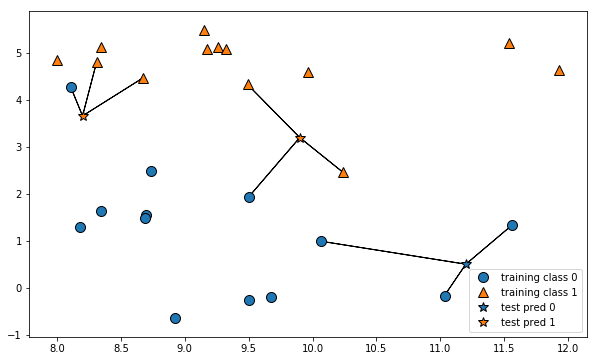

In [2]:
plt.figure(figsize=(10, 6))
mglearn.plot_knn_classification.plot_knn_classification(n_neighbors=3)

# k и регуляризация

Параметърът $k$ се явява форма на регуляризация. Колкото по-висок е, толкова "по-прост" ще бъде модела (ще открие по-проста зависимост между данните).

In [3]:
def plot_knn_parameter():
    X, y = mglearn.datasets.make_forge()

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    for n_neighbors, ax in zip([1, 3, 9], axes):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
        mglearn.plots.plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
        mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
        ax.set_title("{} neighbour(s)".format(n_neighbors))

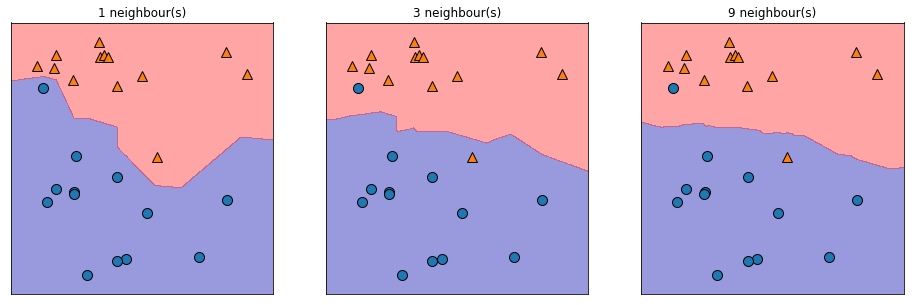

In [4]:
plot_knn_parameter()

## Пример с различен k

* Представете си, че имаме град, разделен от река.
* Хората от двете страни на реката са склонни да имат различни политически ориентации – едните са червени, другите са сини.
* Това съответсвие не е едно към едно – някои червени хора са се преместили от синята страна на реката, някои хора родени в синята страна са станали червени по лични причини.
* Ще се опитаме да предвидим политическата ориентация на хората на база координатите на които живеят. Няма да имаме 100% успеваемост, тъй като координатите на жилището не са достатъчна информация да предвидим точно.
* Ще си синтезираме dataset със `make_moons` който да моделира този казус.

`make_moons` създава два полумесеца, вложени един в друг.

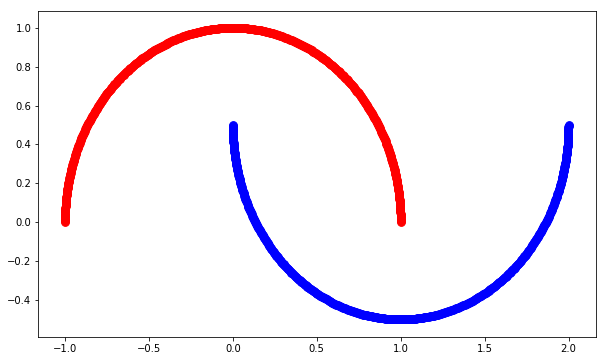

In [5]:
X, y = make_moons(1000, noise=0, random_state=0)
red = X[y == 0]
blue = X[y == 1]
plt.figure(figsize=(10, 6))
plt.scatter(red[:, 0],  red[:, 1],  color='red', alpha=1, s=60)
plt.scatter(blue[:, 0], blue[:, 1], color='blue', alpha=1, s=60);

Може да си представите как реката минава между тях.

`make_moons` има параметър `noise` който въвежда шум. Например:

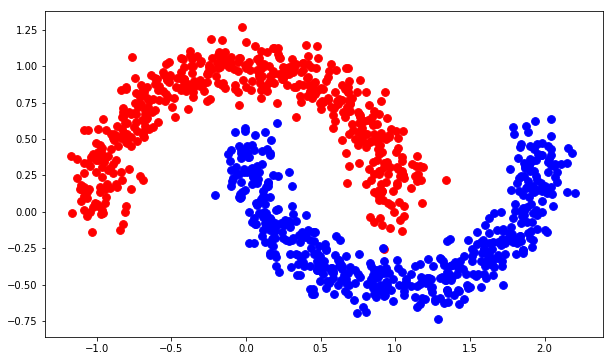

In [6]:
X, y = make_moons(1000, noise=0.1, random_state=0)
red = X[y == 0]
blue = X[y == 1]
plt.figure(figsize=(10, 6))
plt.scatter(red[:, 0],  red[:, 1],  color='red', alpha=1, s=60)
plt.scatter(blue[:, 0], blue[:, 1], color='blue', alpha=1, s=60);

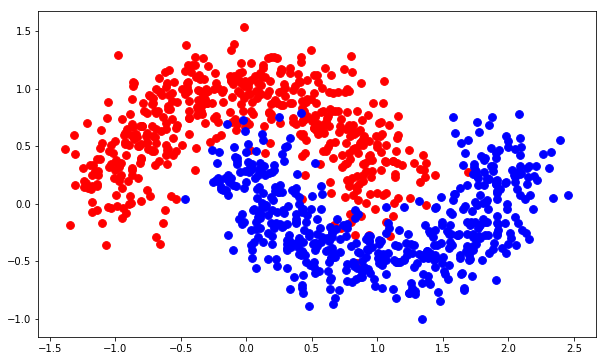

In [7]:
X, y = make_moons(1000, noise=0.2, random_state=0)
red = X[y == 0]
blue = X[y == 1]
plt.figure(figsize=(10, 6))
plt.scatter(red[:, 0],  red[:, 1],  color='red', alpha=1, s=60)
plt.scatter(blue[:, 0], blue[:, 1], color='blue', alpha=1, s=60);

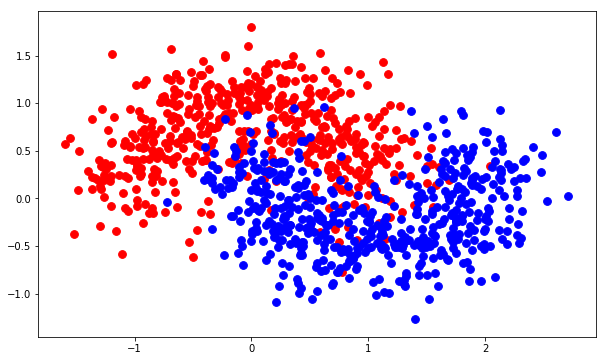

In [8]:
X, y = make_moons(1000, noise=0.3, random_state=0)
red = X[y == 0]
blue = X[y == 1]
plt.figure(figsize=(10, 6))
plt.scatter(red[:, 0],  red[:, 1],  color='red', alpha=1, s=60)
plt.scatter(blue[:, 0], blue[:, 1], color='blue', alpha=1, s=60);

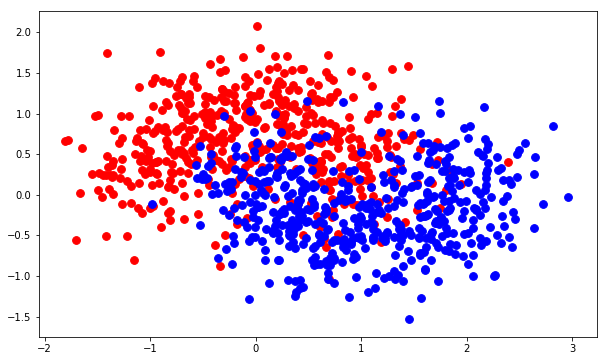

In [9]:
X, y = make_moons(1000, noise=0.4, random_state=0)
red = X[y == 0]
blue = X[y == 1]
plt.figure(figsize=(10, 6))
plt.scatter(red[:, 0],  red[:, 1],  color='red', alpha=1, s=60)
plt.scatter(blue[:, 0], blue[:, 1], color='blue', alpha=1, s=60);

Ще ползваме такъв шум 0.4 за нашия пример.

Нека си създадем dataset начисто и да го разделим на тренировъчен и тестов.

In [10]:
X, y = make_moons(1500, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Да видим как изглежда отново:

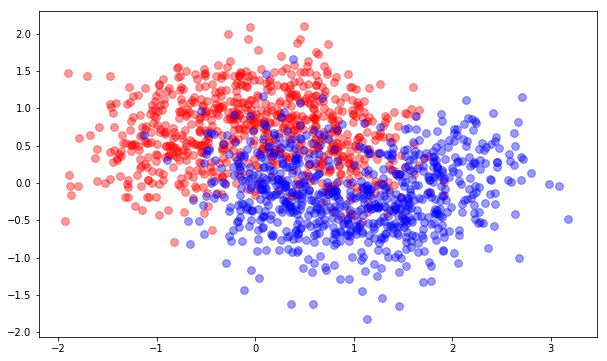

In [11]:
red = X[y == 0]
blue = X[y == 1]
plt.figure(figsize=(10, 6))
plt.scatter(red[:, 0],  red[:, 1],  color='red', alpha=0.4, s=60)
plt.scatter(blue[:, 0], blue[:, 1], color='blue', alpha=0.4, s=60);

Нека да видим как се държи kNN с няколко различни стойности за k:

In [12]:
for k in [1, 7, 21, 501]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    
    train_score = clf.score(X_train, y_train)
    test_score  = clf.score(X_test, y_test)
    
    print("k = {:3}, train score = {:1.5f}, test score = {:1.5f}".format(k, train_score, test_score))

k =   1, train score = 1.00000, test score = 0.76800
k =   7, train score = 0.88444, test score = 0.82933
k =  21, train score = 0.87733, test score = 0.84533
k = 501, train score = 0.82844, test score = 0.81600


Нека всъщност начертаем графика. Ще ползваме следната функция:

In [13]:
def plot_knn_scores(ks):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, train_scores, color='blue', label='train score')
    plt.plot(ks, test_scores, color='green', label='test score')
    plt.legend()

Така изглеждат нещата за $k \in [1, 10)$:

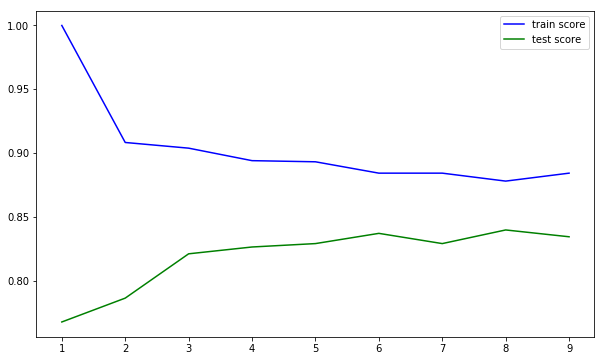

In [14]:
plot_knn_scores(range(1, 10))

Нека да видим $k \in [1, 100)$:

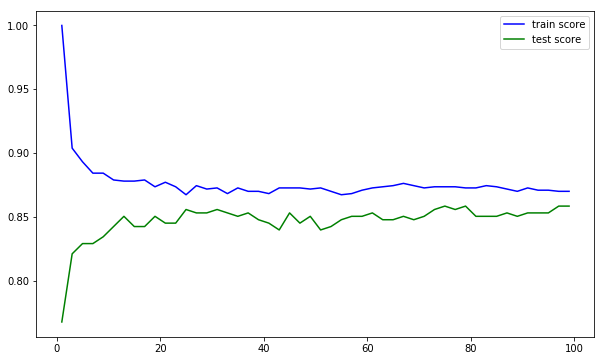

In [15]:
plot_knn_scores(range(1, 100, 2))

И финално, $k \in [1, 1130)$:

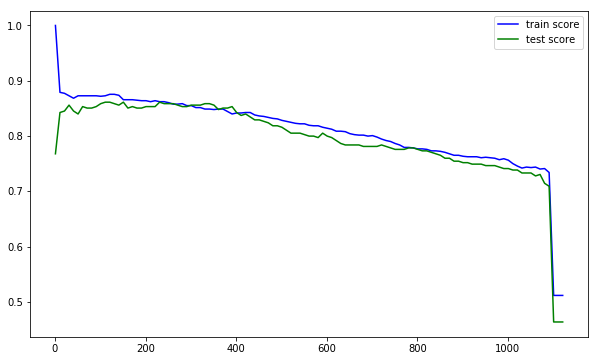

In [16]:
plot_knn_scores(range(1, 1130, 10))

Тук виждаме следните неща:

* С опростяването на модела, train score-а намалява (почти монотонно)
* Най-сложния модел има нисък test score. С опростяването му test score започва да расте, но от един момент нататък започва да намалява.

От графиката може да видим, че при $k = 1$ има overfitting, докато при по-големи $k$ ($k > 400$) започва да има underfitting.

Търсим някакъв $k$, който да има оптимален train score (например $k = 351$ се приближава).

Друг начин да осмислим резултата е като начертаем decision boundary. За да стане това, просто оцветяваме всяка точка от картата с цвета, който класификатора ще предвиди.

За целта ползваме следните функции:

In [17]:
def plot_decision_boundary(classifier, alpha=1):
    plt.figure(figsize=(10, 6))
    eps = X.std() / 2.
    ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 700)
    yy = np.linspace(y_min, y_max, 700)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    
    cmap = matplotlib.colors.ListedColormap(['red', 'blue'])
    decision_values = classifier.predict(X_grid)
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max, y_min, y_max),
              aspect='auto', origin='lower', alpha=alpha, cmap=cmap)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [18]:
def summarize_knn(k):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    print("K = {}".format(k))
    print("train score: {}".format(classifier.score(X_train, y_train)))
    print("test score:  {}".format(classifier.score(X_test, y_test)))
    plot_decision_boundary(classifier)

Ето как изглеждат нещата при $k = 1$.

K = 1
train score: 1.0
test score:  0.768


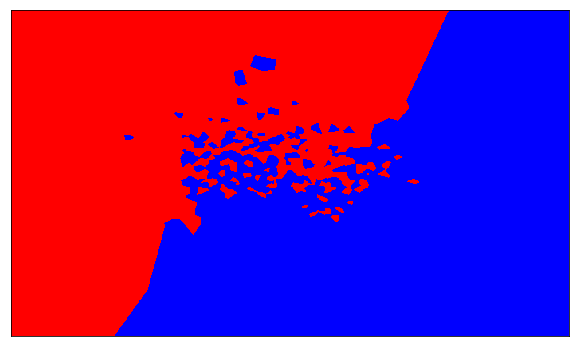

In [19]:
summarize_knn(1)

Тук виждаме доста научен шум и малко острови.

Увеличавайки $k$, научения шум намалява и островите стават по-малки:

K = 3
train score: 0.904
test score:  0.8213333333333334


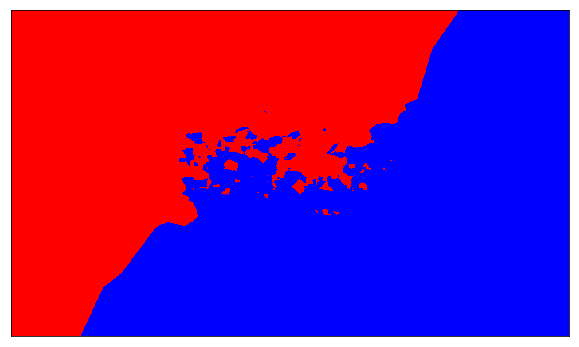

In [20]:
summarize_knn(3)

K = 9
train score: 0.8844444444444445
test score:  0.8346666666666667


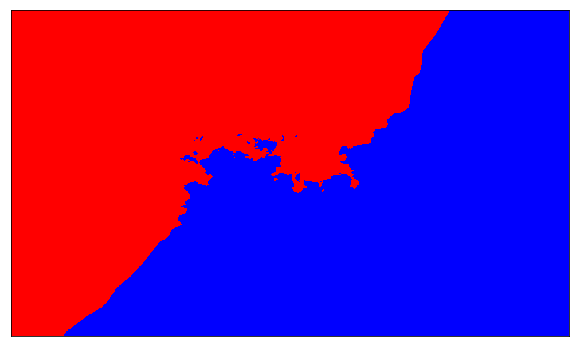

In [21]:
summarize_knn(9)

K = 57
train score: 0.8684444444444445
test score:  0.8506666666666667


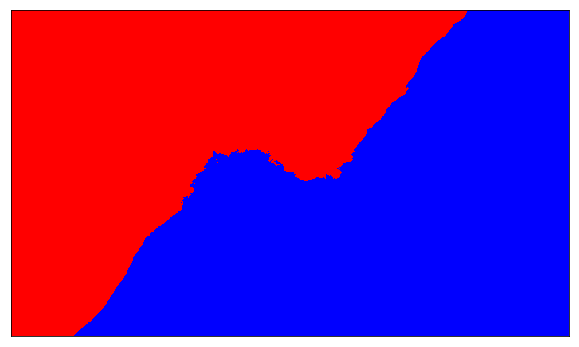

In [22]:
summarize_knn(57)

При $k = 151$ започваме да виждаме очакваните резултати:

K = 151
train score: 0.8657777777777778
test score:  0.8613333333333333


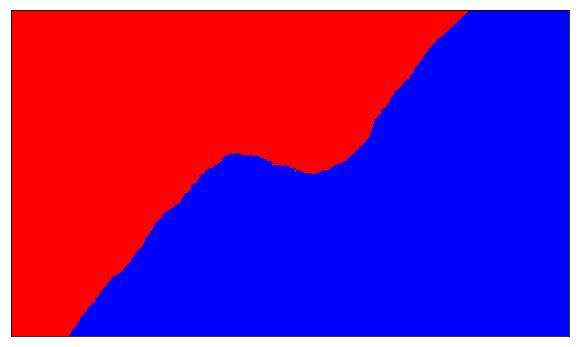

In [23]:
summarize_knn(151)

Ако прекалим обаче, модела не научава добре границата:

K = 501
train score: 0.8284444444444444
test score:  0.816


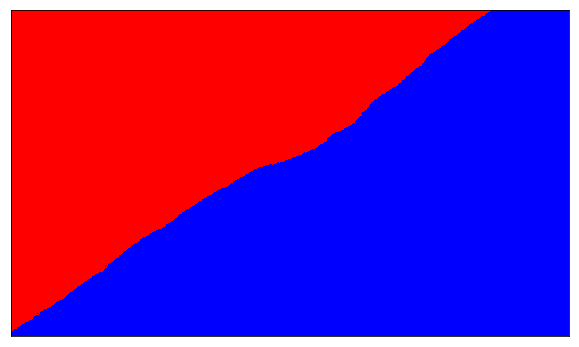

In [24]:
summarize_knn(501)

Може и да начертаем как се променят train и test scores при размера на входните данни ($n$).

In [25]:
def plot_knn_with_different_datasets():
    percentages = range(10, 100, 1)
    test_scores = []
    train_scores = []
    for percent in percentages:
        size = int(len(X_train) * ((percent + 1) / 100.0))
        X_subset = X_train[:size, :]
        y_subset = y_train[:size]
        
        clf = KNeighborsClassifier(n_neighbors=123)
        clf.fit(X_subset, y_subset)
        
        train_score = clf.score(X_subset, y_subset)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
        
    plt.figure(figsize=(10, 6))
    plt.plot(percentages, train_scores, color='blue', label='train score')
    plt.plot(percentages, test_scores, color='green', label='test score')
    plt.legend()

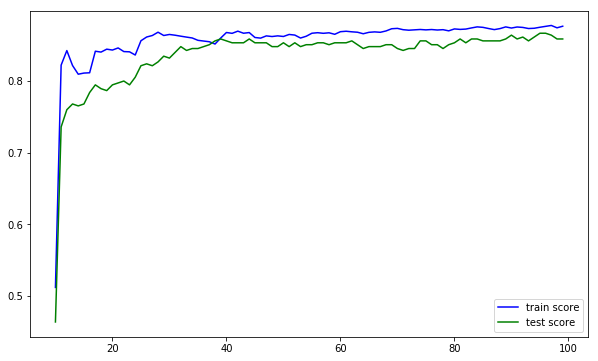

In [26]:
plot_knn_with_different_datasets()

Виждаме, че колкото повече данни имаме, толкова по-добре се справят train и test score.

Един извод, който може да си извадите, е че колкото повече данни имаме, толкова по-малко склонен е алгоритъма към overfitting.

# Линейна регресия и boston

Нека да разгледаме boston dataset-а и да се опитаме да приложим линейна регресия с различни регуларизации.

Първо, нека да погледнем данните:

In [27]:
boston = load_boston()

Тук подмолно въвеждаме една библиотека (`pandas`) която прави работата с таблици по-лесна:

In [28]:
frame = pd.DataFrame(boston.data, columns=boston.feature_names)
frame.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Да видим какво бяха отделните колони:

In [29]:
print(boston.DESCR[253:1222])

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's


Нека пробваме да натренираме проста линейна регресия:

In [30]:
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = LinearRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.720180087155
test score:  0.787887336086


Тук всякаш нямаме overfitting. Но пък може би ще успеем да постигнем резултат ако помасажираме входните данни.

## Полиномни feature-и

Един подход, който често дава добри резултати е да добавим степенни на feature-ите. Например, ако имаме два feature – $x_1$ и $x_2$, да добавим и $x_1^2$, $x_1 x_2$ и $x_2^2$ като нови feature-и.

В scikit learn има клас, който може да направи това:

In [31]:
polynomial = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
data = np.array([[2.0, 5.0],
                 [3.0, 4.0]])
polynomial.fit_transform(data)

array([[  1.,   2.,   5.,   4.,  10.,  25.],
       [  1.,   3.,   4.,   9.,  12.,  16.]])

Друга обработка на данните, която ще направим, е скалиране. За целта имаме `StandardScaler()`, който изважда средно аритметичното и дели на стандартното отклонение. Това (условно) разпределя всички данни в интервала $(-4, -4)$.

In [32]:
frame[['TAX']].describe()

,TAX
count,506.000000
mean,408.237154
std,168.537116
min,187.000000
25%,279.000000
50%,330.000000
75%,666.000000
max,711.000000


In [33]:
transformed = StandardScaler().fit_transform(frame[['TAX']])
pd.DataFrame(transformed).describe()

,0
count,506.000000
mean,0.000000
std,1.000990
min,-1.313990
25%,-0.767576
50%,-0.464673
75%,1.530926
max,1.798194


Ще прекараме оригиналния dataset през тези трансформации:

In [34]:
data = boston.data
data = StandardScaler().fit_transform(data)
data = PolynomialFeatures(degree=2, include_bias=False).fit_transform(data)

Да видим формата на оригиналните данни и на трансформираните:

In [35]:
print("original data shape:   ", boston.data.shape)
print("transformed data shape:", data.shape)

original data shape:    (506, 13)
transformed data shape: (506, 104)


Нека си разделим данните на тренировъчни и тестови:

In [36]:
X, y = data, boston.target
X_train, X_test, y_train, y_test = train_test_split(data, boston.target, random_state=0)

Преди да тренираме модел, нека си припомним трите вида линейна регресия:

* `LinearRegression` – най-простата възможна, без регуляризация.
* `Ridge` – вариант с L2 регуляризация, която кара всички коефициенти да се опитват да бъдат малки
* `Lasso` – вариант с L1 регуларизация, която кара някои коефициенти да бъдат точно 0

Нека първо да пробваме с `Ridge`:

In [37]:
model = Ridge().fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print("train:", train_score)
print("test: ", test_score)

train: 0.948522138839
test:  0.672365747433


Тук има стабилен overfit.

Регуляризацията се контролира с един параметър `alpha`. Колкото е по-голям, толкова по-силна е регуляризацията (т.е. модела се опитва да е по-прост). Нека да начертаем train и test score при различни стойности на `alpha`.

In [38]:
def plot_ridge_learning_rate():
    alphas = np.linspace(0.00001, 200, 5000)
    train_scores = []
    test_scores = []
    for alpha in alphas:
        model = Ridge(alpha=alpha).fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(alphas, train_scores, color='blue', label='train score')
    plt.plot(alphas, test_scores, color='green', label='test score')
    plt.legend()

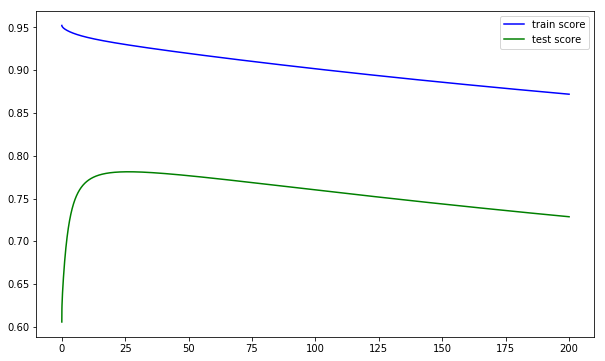

In [39]:
plot_ridge_learning_rate()

Отново виждаме тендецния train score да намалява монотонно, докато test score първо да расте и после да намалява. Тук оптимален резултат се вижда някъде около $\alpha = 25$.

Нека сега пробваме с `Lasso`:

In [40]:
model = Lasso().fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
features_used = np.sum(model.coef_ != 0)

print("train:        ", train_score)
print("test:         ", test_score)
print("features used: {}/{}".format(features_used, len(model.coef_)))

train:         0.803457507808
test:          0.69462412474
features used: 11/104


Тук отново изглежда, че имаме overfit. Също, забележете, че модела ползва само 11 от всичките 104 feature-а.

Пак ще начертаем графика:

In [41]:
def plot_lasso_learning_rate():
    alphas = np.linspace(0.0001, 0.5, 1000)
    train_scores = []
    test_scores = []
    features_used = []
    for alpha in alphas:
        model = Lasso(alpha=alpha, random_state=0, max_iter=1_000_000).fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        features = np.sum(model.coef_ != 0)

        train_scores.append(train_score)
        test_scores.append(test_score)
        features_used.append(features)

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    axes = axes.ravel()

    axes[0].plot(alphas, train_scores, color='blue', label='train score')
    axes[0].plot(alphas, test_scores, color='green', label='test score')
    axes[0].legend()

    axes[1].plot(alphas, features_used, label='features used')
    axes[1].legend();

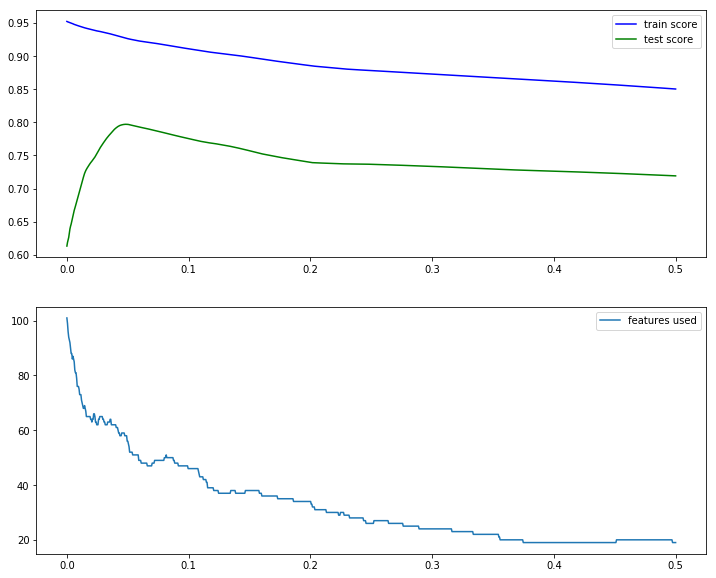

In [42]:
plot_lasso_learning_rate()

Отново се наблюдава същата тенденция. Има стойности на `alpha`, за които резултата е оптимален (около $\alpha=0.4$).

Въпреки това, има голяма разлика между train score и test score. Това може да се дължи на няколко неща:

* Модела научава твърде много шум заради полиномните feature-и.
* Данните са твърде малко (379 апартамента)
* Feature-ите са твърде много за данните (104)

## Размер на данните и регуляризация

Регуляризацията може да намали overfit-а при малко данни. Ето пример:

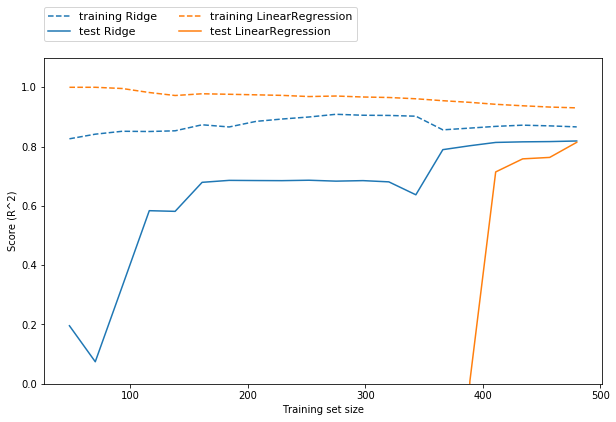

In [43]:
plt.figure(figsize=(10, 6))
mglearn.plots.plot_ridge_n_samples()

Тук се вижда, че `Ridge` се справя по-добре при по-малък training set. Линейната регресия без регуляризация има нужда от почти 400 точки за да научи нещо, докато `Ridge` се оправя (някак) и с по-малко.

# Inference и линейна регресия

Като забавен aside – може да ползваме линейна регресия да по какъв начин различните feature допринасят на крайния резултат. Например, може да натренираме линейна регресия за апартаментите в Бостън и да видим всеки feature как допринася на цената.

Първо ще настренираме линейна регресия:

In [44]:
data = StandardScaler().fit_transform(boston.data)
X_train, X_test, y_train, y_test = train_test_split(data, boston.target)

linear = LinearRegression()
linear.fit(X_train, y_train)

print("train:", linear.score(X_train, y_train))
print("test: ", linear.score(X_test, y_test))

train: 0.755904361763
test:  0.681287787401


След това може да ползваме една библиотека, `eli5` (от Explain it Like I'm 5) за да видим стойностите на коефициентите:

In [45]:
eli5.sklearn.explain_weights.explain_linear_regressor_weights(linear, feature_names=boston.feature_names)

Weight?,Feature
+22.544,<BIAS>
+2.922,RAD
+2.866,RM
+1.307,ZN
+1.080,B
+0.738,CHAS
+0.024,INDUS
-0.282,AGE
-1.303,CRIM
-1.676,NOX


Може да видим че RAD (достъпа до магистрали) вдига цената на апартамента, докато DIS (дистанцията от employment център) я сваля.

In [46]:
print(boston.DESCR[253:1222])

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's



# Moons с полиномни feature-и и логистична регресия

Нека just for fun да се върнем към първоначалния dataset и да пробваме с логистична регресия и полиномни feature-и.

In [47]:
X, y = make_moons(1000, noise=0.5, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

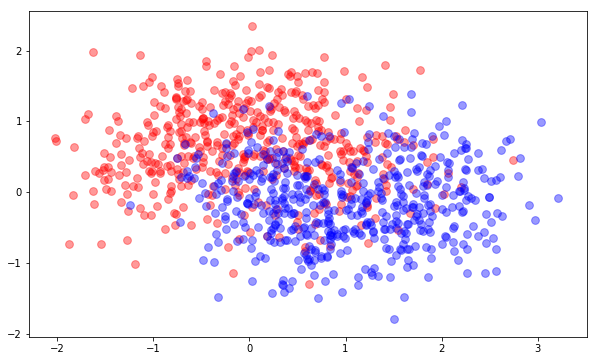

In [48]:
red = X[y == 0]
blue = X[y == 1]
plt.figure(figsize=(10, 6))
plt.scatter(red[:, 0],  red[:, 1],  color='red', alpha=0.4, s=60)
plt.scatter(blue[:, 0], blue[:, 1], color='blue', alpha=0.4, s=60);

Нека натренираме логистична регресия и да покажем decision boundary-то:

train: 0.822666666667
test:  0.772


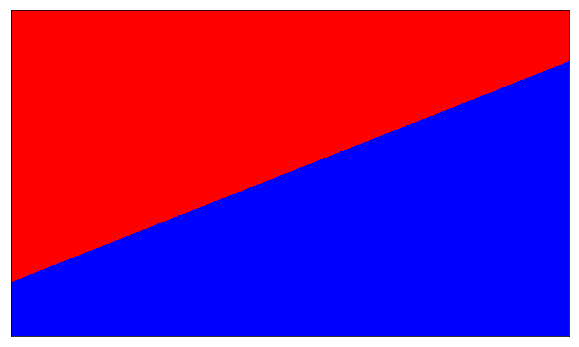

In [49]:
reg = LogisticRegression().fit(X_train, y_train)
print("train:", reg.score(X_train, y_train))
print("test: ", reg.score(X_test, y_test))

plot_decision_boundary(reg)

Неизненадващо, логистичната регресия търси права, която да разделя нашия град на две и това не дава добър резултат.

Нека да пробваме да видим какво става с полиноми от по-висока степен и различна регуляризация:

In [50]:
def plot_logistic_moons(X, y, degree=1, C=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    pipeline = make_pipeline(
        PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False),
        LogisticRegression(C=C)
    )
    classifier = pipeline.fit(X_train, y_train)
    
    print("train:", classifier.score(X_train, y_train))
    print("test: ", classifier.score(X_test, y_test))

    plt.figure(figsize=(10, 6))
    eps = X.std() / 2.
    ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 700)
    yy = np.linspace(y_min, y_max, 700)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]

    cmap = matplotlib.colors.ListedColormap(['red', 'blue'])
    decision_values = classifier.predict(X_grid)
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max, y_min, y_max),
              aspect='auto', origin='lower', alpha=1, cmap=cmap)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

При втора степен не получаваме добри резултати.

train: 0.821333333333
test:  0.764


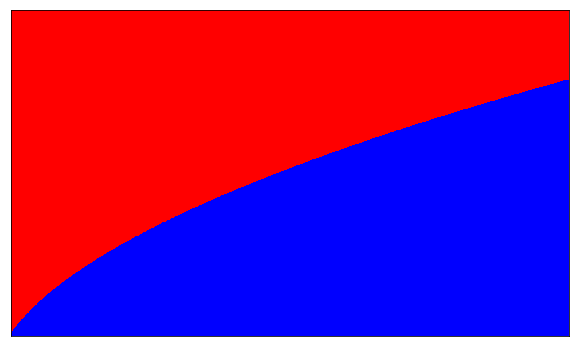

In [51]:
plot_logistic_moons(X, y, degree=2, C=1)

При трета степен почти получаваме нещо разумно:

train: 0.84
test:  0.792


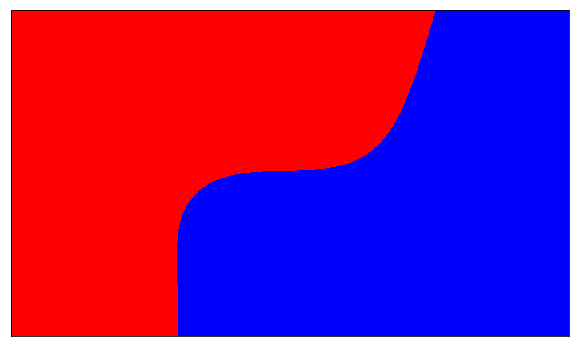

In [52]:
plot_logistic_moons(X, y, degree=3, C=10)

Ако продължим нагоре, нещата стават все по-шантави:

train: 0.836
test:  0.784


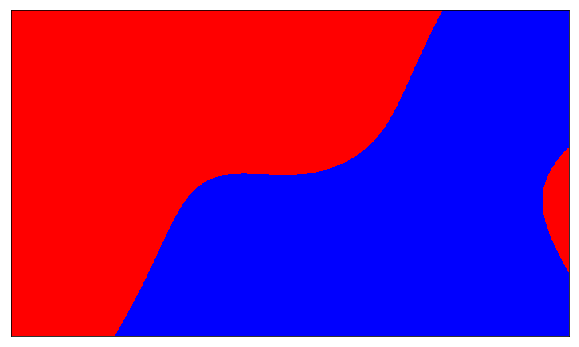

In [53]:
plot_logistic_moons(X, y, degree=4, C=1)

train: 0.84
test:  0.776


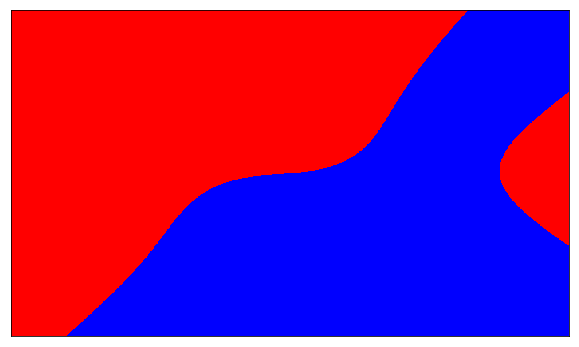

In [54]:
plot_logistic_moons(X, y, degree=6, C=0.1)

train: 0.844
test:  0.788


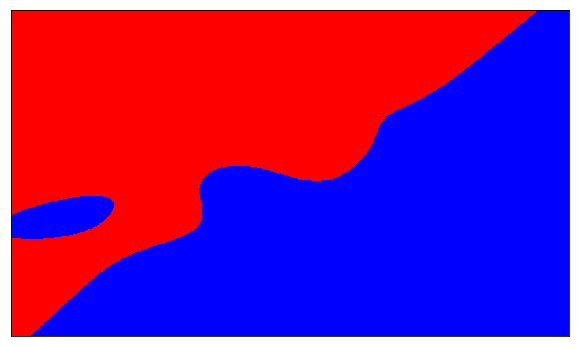

In [55]:
plot_logistic_moons(X, y, degree=7, C=100)

Колкото и да се мъчим по този начин, едва ли ще получим добър модел с логистичната регресия.

Извод: не всеки модел е подходящ за всеки dataset.

И ей така за идеята, нека натренираме и една невронна мрежа:

train: 0.841333333333
test:  0.796


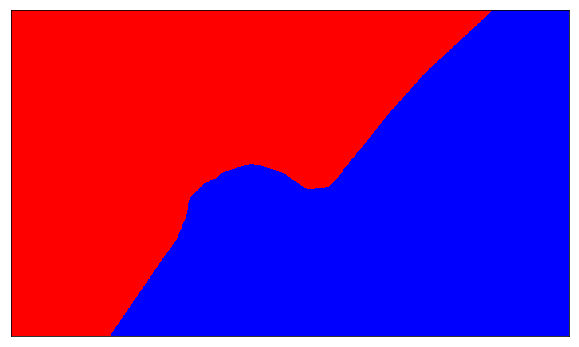

In [56]:
mlp = MLPClassifier(solver='lbfgs', random_state=0, alpha=0.3, max_iter=1000)
mlp.fit(X_train, y_train)

print("train:", mlp.score(X_train, y_train))
print("test: ", mlp.score(X_test, y_test))

plot_decision_boundary(mlp)

# Обобщение

Накратко между overfit/underfit и данни, сложност и feature може да се обобщи така:

|                    | по-малко | повече    |
|:-------------------|:---------|:----------|
| сложност на модела | underfit | overfit   |
| данни              | overfit  | underfit? |
| feature-и          | underfit | overfit   |

Тази таблица добре обобщава интуицията.

Струва си да се отбележи, че повече данни обикновено винаги е по-добре и не непременно ще доведе до underfit – обикновено води просто до по-добри резултати

# Въпроси

* http://fmi.machine-learning.bg/
* fmi@machine-learning.bg